In [2]:
from utils import get_exp_data, downsample_arr, steps2ms, ms2steps
from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd 
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d

from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, TimeSeriesSplit

import matplotlib.pylab as plt
import seaborn as sns

# Load Experimental Data

In [3]:
# load matlab data file
matlab_file = Path(r'./data/EphysData/A026-20200323-01.mat')
df_raw = get_exp_data(matlab_file)
gr_raw = df_raw.groupby('trial')

n_trials = len([ i for i in gr_raw.groups if i > 0]) # 0 and -1 are before and after first and last trial, respectively
print('There are {} trials'.format(str(n_trials)))

There are 246 trials


In [3]:
# example: raw data for trial 1
d = gr_raw.get_group(1)
print('Time step: {}'.format(str(len(d))))
print('{} time step is {} ms'.format('1', str(steps2ms(1))))

feat = [ i for i in d.columns if not i.startswith('unt_') ]
feat.remove('trial') # trial number is not a feature
targ = [ i for i in d.columns if i.startswith('unt_') ]
print('The features are')
print('    ', ' '.join(feat), '(note that xtr is not a true feature)')


print('The targets are')
for i in range(0, len(targ), 10):
    print('    ', ' '.join(targ[i:i+10]))


Time step: 6449
1 time step is 0.8 ms
The features are
     dst lck rwd cue_on cue_off blk_on blk_off xtr (note that xtr is not a true feature)
The targets are
     unt_1 unt_2 unt_3 unt_4 unt_5 unt_6 unt_7 unt_8 unt_9 unt_10
     unt_11 unt_12 unt_13 unt_14 unt_15 unt_16 unt_17 unt_18 unt_19 unt_20
     unt_21 unt_22 unt_23 unt_24 unt_25 unt_26 unt_27 unt_28 unt_29 unt_30
     unt_31 unt_32 unt_33 unt_34 unt_35 unt_36 unt_37 unt_38 unt_39 unt_40
     unt_41 unt_42 unt_43 unt_44 unt_45 unt_46 unt_47 unt_48 unt_49 unt_50
     unt_51 unt_52 unt_53 unt_54 unt_55 unt_56 unt_57 unt_58 unt_59 unt_60
     unt_61 unt_62 unt_63 unt_64 unt_65 unt_66 unt_67 unt_68 unt_69 unt_70
     unt_71 unt_72 unt_73 unt_74 unt_75 unt_76 unt_77 unt_78 unt_79 unt_80
     unt_81 unt_82 unt_83 unt_84


## Plot Raw data

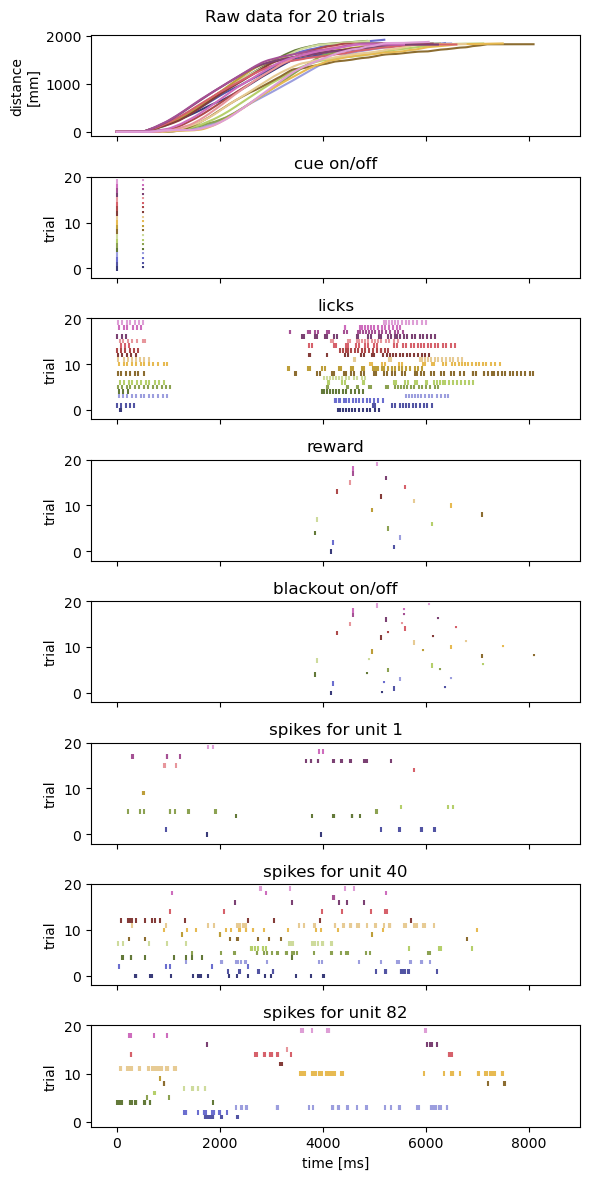

In [5]:
# plot data
dfs = [ gr_raw.get_group(i) for i in range(1, 21) ] # select first 20 trials

fig, axarr = plt.subplots(nrows=8, figsize=(6, 12))
fig.suptitle('Raw data for {} trials'.format(len(dfs)))
plt.set_cmap('jet')
color = lambda x: plt.cm.tab20b(x / len(dfs))

def plot(col):
    'plot columns col from list of dataframes'
    for i, df in enumerate(dfs):
        y = df.loc[:, col]
        x = steps2ms(np.arange(len(y)))
        ax.plot(x, y, color=color(i))

def raster(col, l='-'):
    'plot columns col from list of dataframes'
    for i, df in enumerate(dfs):
        t = df.loc[:, col]
        x = np.where(t == 1)[0]
        x = steps2ms(x)
        ax.eventplot(x, lineoffsets=i, color=color(i), ls=l)

ax = axarr[0]
plot('dst')
ax.set_ylabel('distance\n[mm]')

ax = axarr[1]
raster('cue_on')
raster('cue_off', l=':')
ax.set_title('cue on/off')

ax = axarr[2]
raster('lck')
ax.set_title('licks')

ax = axarr[3]
raster('rwd')
ax.set_title('reward')

ax = axarr[4]
raster('blk_on')
raster('blk_off', l=':')
ax.set_title('blackout on/off')

ax = axarr[5]
raster('unt_1')
ax.set_title('spikes for unit 1')

ax = axarr[6]
raster('unt_40')
ax.set_title('spikes for unit 40')

ax = axarr[7]
raster('unt_82')
ax.set_title('spikes for unit 82')

for ax in axarr[:-1]:
    ax.set_xticklabels([])
for ax in axarr[1:]:
    ax.set_ylabel('trial')
    ax.set_ylim(top=len(dfs))
for ax in axarr:
    ax.set_xlim(-500, 9000)
ax.set_xlabel('time [ms]')

fig.tight_layout()

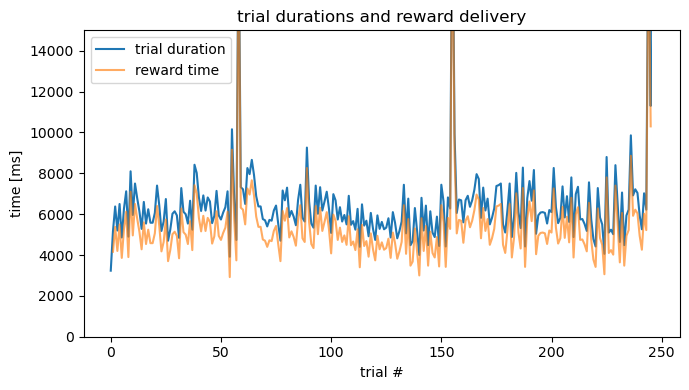

In [6]:
# plot trial durations and reward times
arr = np.empty(len(gr_raw))*np.nan
tot_ts, rwd_ts, n_rwd = deepcopy(arr), deepcopy(arr), deepcopy(arr)
for i, (_, df) in enumerate(gr_raw):
    tot_ts[i] = len(df.loc[:, 'dst'])
    rwd = df.loc[:, 'rwd'] # get rwd arrays
    i_rwd = np.where(rwd == 1)[0] # find indices for rwd
    n_rwd[i] = rwd.sum() # count number of cues
    try: # skip if empty 
        rwd_ts[i] = int(i_rwd)
    except TypeError:
        pass 

fig, axarr = plt.subplots(figsize=(7, 4))
ax = axarr
ax.plot(steps2ms(tot_ts), label='trial duration')
ax.plot(steps2ms(rwd_ts), label='reward time', alpha=0.65)
ax.legend()

ax.set_xlabel('trial #')
ax.set_ylabel('time [ms]')
ax.set_title('trial durations and reward delivery')
ax.set_ylim(0, 15000)

fig.tight_layout()

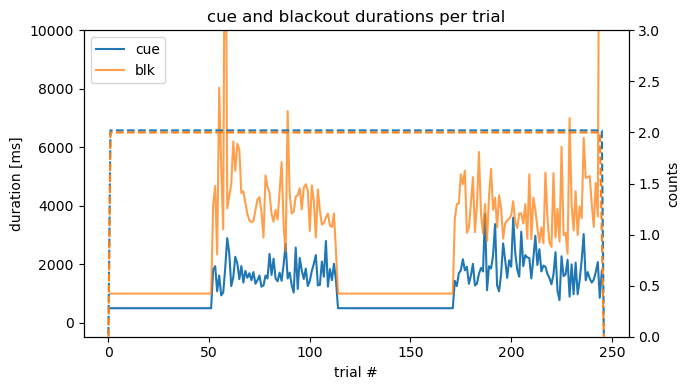

In [7]:
# plot cue and blackout durations
arr = np.empty(len(gr_raw))*np.nan
n_cue, n_blk = deepcopy(arr), deepcopy(arr)
delta_cue, delta_blk = deepcopy(arr), deepcopy(arr)
for i, (_, df) in enumerate(gr_raw):
    on, off = df.loc[:, 'cue_on'], df.loc[:, 'cue_off'] # get cue arrays
    i_on, i_off = np.where(on == 1)[0], np.where(off == 1)[0] # find indices for cues
    n_cue[i] = len(i_on) + len(i_off) # count number of cues
    try:
        delta_cue[i] = int(i_off) - int(i_on) # calculate difference
    except TypeError: # skip if empty
        pass

    on, off = df.loc[:, 'blk_on'], df.loc[:, 'blk_off'] # same as for cue
    i_on, i_off = np.where(on == 1)[0], np.where(off == 1)[0]
    n_blk[i] = len(i_on) + len(i_off)
    try:
        delta_blk[i] = int(i_off) - int(i_on)
    except TypeError: 
        pass

fig, axarr = plt.subplots(figsize=(7, 4))
ax = axarr
ax.plot(steps2ms(delta_cue), label='cue')
ax.plot(steps2ms(delta_blk), label='blk', alpha=0.75)
ax.set_ylim(top=10000)
ax.set_xlabel('trial #')
ax.set_ylabel('duration [ms]')
ax.set_title('cue and blackout durations per trial')
ax.legend()

ax = ax.twinx()
ax.plot(n_cue+0.02, ls='--')
ax.plot(n_blk, ls='--')
ax.set_ylim(0, 3)
ax.set_ylabel('counts')

fig.tight_layout()

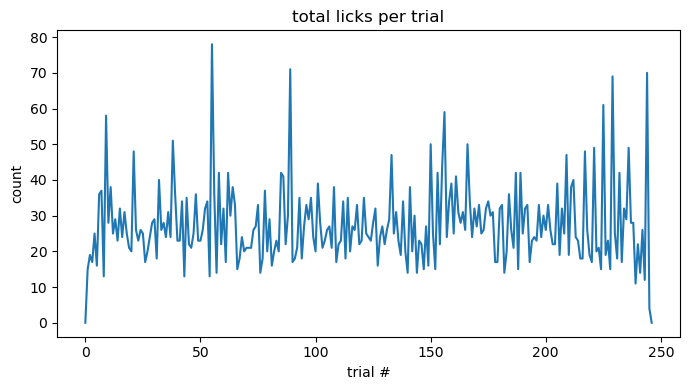

In [8]:
# plot trial durations
lck = np.array([df.loc[:, 'lck'].sum() for _, df in gr_raw])

fig, axarr = plt.subplots(figsize=(7, 4))
ax = axarr
ax.plot(lck)

ax.set_xlabel('trial #')
ax.set_ylabel('count')
ax.set_title('total licks per trial')
# ax.set_ylim(0, 1500)

fig.tight_layout()

unt order is: unt_1 unt_2 unt_3 unt_4 unt_5 unt_6 unt_7 unt_8 unt_9 unt_10 unt_11 unt_12 unt_13 unt_14 unt_15 unt_16 unt_17 unt_18 unt_19 unt_20 unt_21 unt_22 unt_23 unt_24 unt_25 unt_26 unt_27 unt_28 unt_29 unt_30 unt_31 unt_32 unt_33 unt_34 unt_35 unt_36 unt_37 unt_38 unt_39 unt_40 unt_41 unt_42 unt_43 unt_44 unt_45 unt_46 unt_47 unt_48 unt_49 unt_50 unt_51 unt_52 unt_53 unt_54 unt_55 unt_56 unt_57 unt_58 unt_59 unt_60 unt_61 unt_62 unt_63 unt_64 unt_65 unt_66 unt_67 unt_68 unt_69 unt_70 unt_71 unt_72 unt_73 unt_74 unt_75 unt_76 unt_77 unt_78 unt_79 unt_80 unt_81 unt_82 unt_83 unt_84


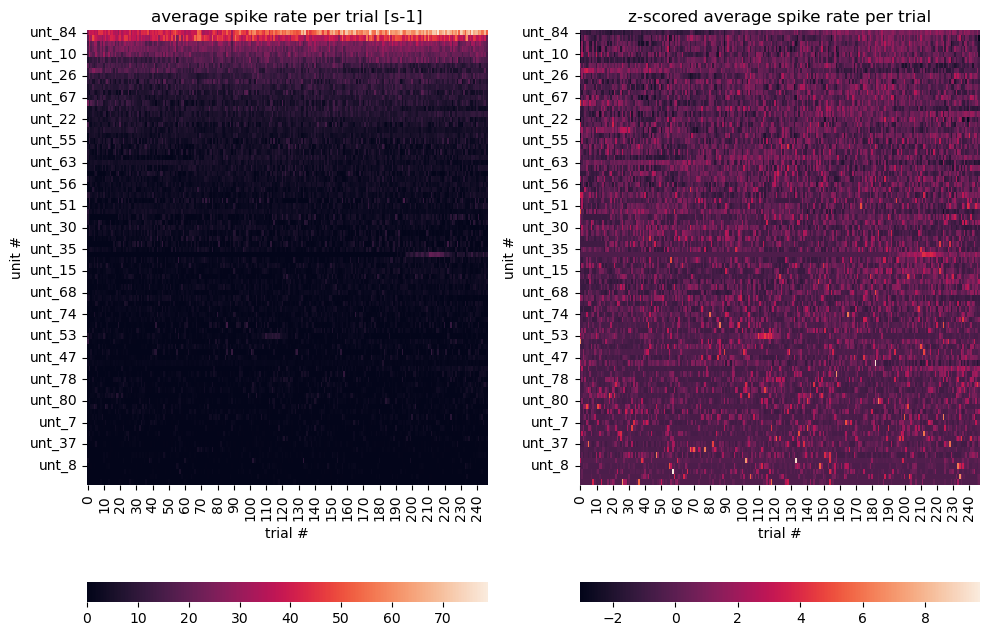

In [9]:
# plot avg spike times
col_spk = [ i for i in df_raw.columns if i.startswith('unt_') ]
spk = np.ones( (len(gr_raw), len(col_spk)) )*np.nan

for i, (_, df) in enumerate(gr_raw):
    t = len(df.loc[:, 'dst'])
    t = steps2ms(t) / 1000
    s = df.loc[:, col_spk]
    n = s.sum()
    r = n / t
    spk[i] = r

df = pd.DataFrame(data=spk.T, index=col_spk, columns=gr_raw.groups.keys())
df = df.loc[df.sum(axis=1).sort_values(ascending=False).index, :]

fig, axarr = plt.subplots(ncols=2, figsize=(10, 7))
ax = axarr[0]
sns.heatmap(ax=ax, data=df, cbar_kws=dict(location='bottom'))
ax.set_title('average spike rate per trial [s-1]')
ax = axarr[1]
sns.heatmap(ax=ax, data=df.apply(zscore, axis=1), cbar_kws=dict(location='bottom'))
ax.set_title('z-scored average spike rate per trial')

for ax in axarr:
    ax.set_xlabel('trial #')
    ax.set_ylabel('unit #')

print('unt order is:', ' '.join(col_spk))
fig.tight_layout()

## Select trials for processing

In [4]:
# example: select all good trials

# collect types for each trial, based on xtr column
# TODO: this is very much session-specific, finish function get_good_trials
ids, typ = [], [] 
for gr, df in gr_raw:
    ids.append(gr)
    i = df.loc[:, 'xtr'].unique()
    if np.array_equal(i, np.array([0])):
        typ.append('good')
    else:
        typ.append('bad')

typ[0] = 'start/stop'
typ[-1] = 'start/stop'

df_trl = pd.DataFrame({
    'ids': ids,
    'type': typ,
})

# subsets of good trials
gr_trl = df_trl.groupby('type')
df_good = gr_trl.get_group('good')
ids_good = df_good.loc[:,'ids'].values

# dataframe containing all valid trials
all_good = pd.concat([ gr_raw.get_group(s) for s in ids_good ])
all_good

,trial,dst,lck,rwd,cue_on,cue_off,blk_on,blk_off,xtr,unt_1,...,unt_75,unt_76,unt_77,unt_78,unt_79,unt_80,unt_81,unt_82,unt_83,unt_84
4042,1,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4043,1,0.009846,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4044,1,0.019692,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4045,1,0.029538,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4046,1,0.039385,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363400,171,1835.560000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1363401,171,1835.568000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1363402,171,1835.576000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1363403,171,1835.584000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split data into train/test sets and cross-validation sets

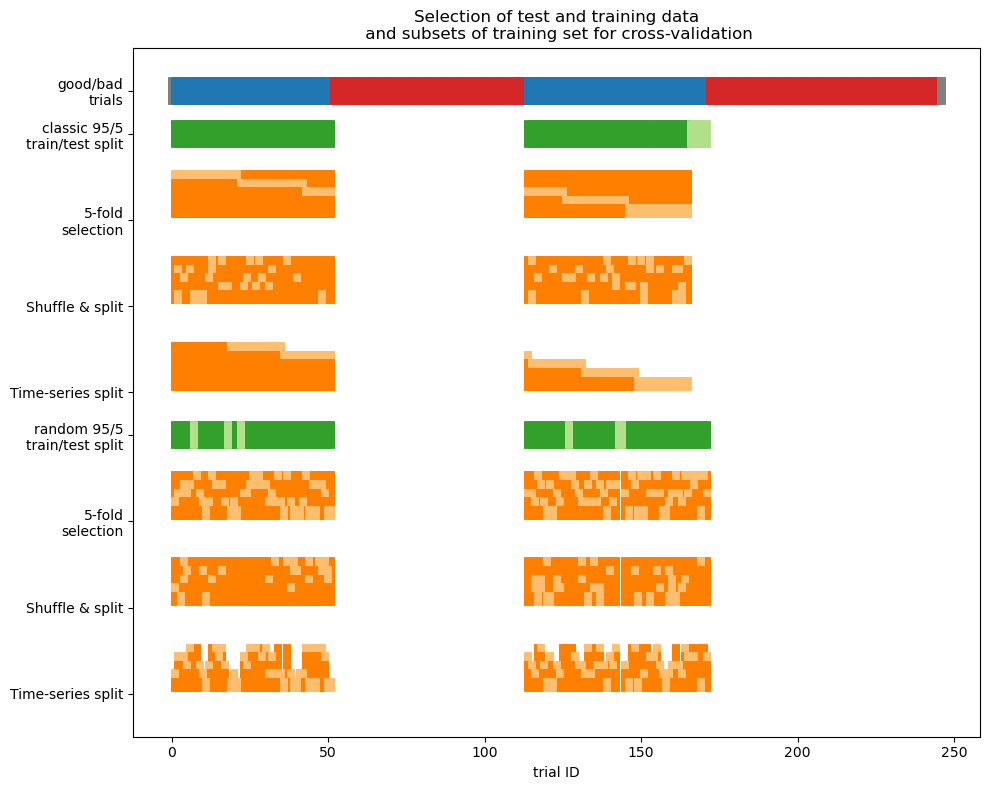

In [11]:
# plot train/test set selection
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.get_cmap('Paired')

def plot_train_test(train, test, y):
    ax.scatter(x=train, y=[y]*len(train), marker='_', lw=20, color=cmap(3/12))
    ax.scatter(x=test, y=[y]*len(test), marker='_', lw=20, color=cmap(2/12))

def plot_folds(train, cv, y):
    for i, (a, b) in enumerate(cv.split(train)):
        ax.scatter(x=train[a], y=[y - i*0.2]*len(a), marker='_', lw=10, color=cmap(7/12))
        ax.scatter(x=train[b], y=[y - i*0.2]*len(b), marker='_', lw=10, color=cmap(6/12))

# entire session
x = df_trl.loc[:, 'ids']
col_dict = {
    'start/stop': 'gray',
    'good': 'tab:blue',
    'bad': 'tab:red'
}
c = [ col_dict[i] for i in df_trl.loc[:, 'type']]
ax.scatter(x=x, y=[0]*len(x), marker='_', lw=20, c=c)

# train test set (not shuffled)
train, test = train_test_split(ids_good, test_size=0.05, shuffle=False)
plot_train_test(train, test, y=-1)

plot_folds(train, cv=KFold(5), y=-2)
plot_folds(train, cv=ShuffleSplit(5), y=-4)
plot_folds(train, cv=TimeSeriesSplit(5), y=-6)

# train test set (shuffled)
train, test = train_test_split(ids_good, test_size=0.05, shuffle=True)
plot_train_test(train, test, y=-8)

plot_folds(train, cv=KFold(5), y=-9)
plot_folds(train, cv=ShuffleSplit(5), y=-11)
plot_folds(train, cv=TimeSeriesSplit(5), y=-13)

ax.set(
    title='Selection of test and training data\n and subsets of training set for cross-validation',
    xlabel='trial ID',
    yticks=[0, -1, -3, -5, -7, -8, -10, -12, -14],
    yticklabels=[
        'good/bad\ntrials',
        'classic 95/5\ntrain/test split',
        '5-fold\nselection',
        'Shuffle & split',
        'Time-series split',
        'random 95/5\ntrain/test split',
        '5-fold\nselection',
        'Shuffle & split',
        'Time-series split'
        ],
    ylim=(-15, 1)
)

fig.tight_layout()

# Feature Generation

In [12]:
# new dataframes for processed data
df_prc = pd.DataFrame(data=df_raw.loc[:, 'trial'], )
gr_prc = df_prc.groupby('trial')

## Distance-related Features

In [13]:
# distance-based features (intra-trial, resets each trial)
norm = lambda x: zscore(x) # normalize: subtract mean and normalize by standard deviation
smooth_w = 125 # sigma=125 time steps (100 ms)
smooth = lambda x: gaussian_filter1d(x, sigma=smooth_w, mode='nearest')  # smooth with gaussian

for i, raw in gr_raw:
    # generate distance-based features (smooth and normalize)
    # distance
    dst_raw = raw.loc[:, 'dst']
    dst_smt = smooth(dst_raw)
    dst_nrm = norm(dst_smt)
    df_prc.loc[raw.index, 'dst'] = dst_nrm

    # distance^2
    dst2_smt = dst_smt**2 # use smoothed dst
    dst2_nrm = norm(dst2_smt)
    df_prc.loc[raw.index, 'dst^2'] = dst2_nrm

    # distance^3
    dst3_smt = dst_smt**3
    dst3_nrm = norm(dst3_smt)
    df_prc.loc[raw.index, 'dst^3'] = dst3_nrm

    # velocity
    vel_smt = np.gradient(dst_smt) # use smoothed dst
    vel_nrm = norm(vel_smt)
    df_prc.loc[raw.index, 'vel'] = vel_nrm

    # acceleration
    acc_raw = np.gradient(vel_smt)
    acc_nrm = norm(acc_raw)
    df_prc.loc[raw.index, 'acc'] = acc_nrm


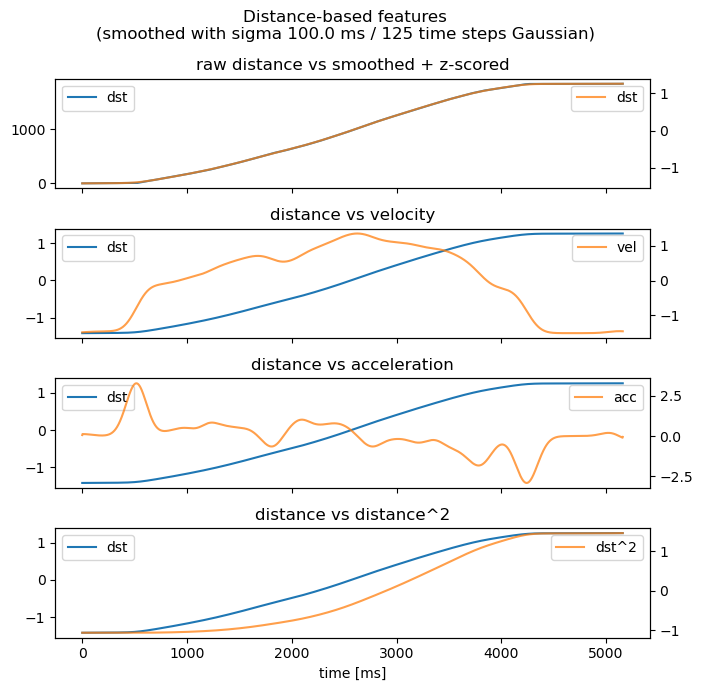

In [14]:
# plot distance-related features
n = 1 # select trial
raw, prc = gr_raw.get_group(n), gr_prc.get_group(n)

def plot(df1, col1, df2, col2):
    y1 = df1.loc[:, col1]
    y2 = df2.loc[:, col2]
    x = steps2ms(np.arange(len(y1)))
    ax.plot(x, y1, color='C0', label=col1)
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1))

    ax2 = ax.twinx()
    ax2.plot(x, y2, color='C1', label=col2, alpha=0.75)
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

fig, axarr = plt.subplots(nrows=4, figsize=(7, 7))
fig.suptitle('Distance-based features\n(smoothed with sigma {} ms / {} time steps Gaussian)'.format(str(steps2ms(smooth_w)), str(smooth_w)))

ax = axarr[0]
plot(raw, 'dst', prc, 'dst')
ax.set_title('raw distance vs smoothed + z-scored'.format(str(steps2ms(smooth_w))))

ax = axarr[1]
plot(prc, 'dst', prc, 'vel')
ax.set_title('distance vs velocity')

ax = axarr[2]
plot(prc, 'dst', prc, 'acc')
ax.set_title('distance vs acceleration')

ax = axarr[3]
plot(prc, 'dst', prc, 'dst^2')
ax.set_title('distance vs distance^2')

for ax in axarr[:-1]:
    ax.set_xticklabels([])

ax = axarr[-1]
ax.set_xlabel('time [ms]')

fig.tight_layout()

## Time-event features

In [15]:
# time-event features (inter-trial, independent of trial structure)
convolve = lambda x, w: np.convolve(x, general_cosine(w, [1, 1]), mode='same') # convolve with raised cosine

# choose time interval for each event (in time steps)
d_cue, n_cue = 625,  5
d_blk, n_blk = 1250, 10
d_rwd, n_rwd = 1250, 10
d_lck, n_lck = 1250, 11

# basis for time intervals: cue, blk
def interval_basis(on, off, d, n):
    x = [ np.zeros_like(on) for i in range(n) ] # empty vectors for new basis
    idx1, idx2  = np.where(on == 1)[0], np.where(off == 1)[0] # get indices for events
    for i1, i2 in zip(idx1, idx2): # cycle through events (assumes pair-wise on/off events)
        b = np.linspace(i1, i2, n) # centers of basis
        b = np.round(b).astype(int) # snap to nearest integer
        for j, k in enumerate(b):
            x[j][k] = 1 
            
    w = int( 2*d / ( n - 1 ) ) # alter width so sum over raised cosines = 1
    x = [ convolve(i, w=w) for i in x] # generate raised cosine at basis center
    
    return x

# basis for time events: rwd, lck
def event_basis(arr, d, n, a): # similar to interval_basis
    x = [ np.zeros_like(on) for i in range(n) ]
    idx  = np.where(arr == 1)[0]
    for i in idx:
        l, r = (-1-a)/2 * d, (1-a)/2 * d # align basis relative to event: after (-1), symmetric (0), before (1)
        b = np.linspace(i + l, i + r, n)
        b = np.round(b).astype(int)
        for j, k in enumerate(b):
            x[j][k] = 1
            
    w = int( 2*d / ( n - 1 ) )
    x = [ convolve(i, w=w) for i in x]
    
    return x

# cues
on, off = df_raw.loc[:, 'cue_on'], df_raw.loc[:, 'cue_off']
bas = interval_basis(on, off, d=d_cue, n=n_cue) # d is cue length, n is number of basis functions
ftr = [ 'cue_{}'.format(str(i)) for i in range(n_cue) ]
for f, b in zip(ftr, bas):
    df_prc.loc[:, f ] = b

# blackouts
on, off = df_raw.loc[:, 'blk_on'], df_raw.loc[:, 'blk_off']
bas = interval_basis(on, off, d=d_blk, n=n_blk) # d is cue length, n is number of basis functions
ftr = [ 'blk_{}'.format(str(i)) for i in range(n_blk) ]
for f, b in zip(ftr, bas):
    df_prc.loc[:, f ] = b

# licks
arr = df_raw.loc[:, 'lck']
bas = event_basis(arr, d=d_lck, n=n_lck, a=0) # n basis functions spread over d aligned to a
ftr = [ 'lck_{}'.format(str(i)) for i in range(n_lck) ]
for f, b in zip(ftr, bas):
    df_prc.loc[:, f ] = b

# rewards
arr = df_raw.loc[:, 'rwd']
bas = event_basis(arr, d=d_rwd, n=n_rwd, a=-1) # n basis functions spread over d aligned to a
ftr = [ 'rwd_{}'.format(str(i)) for i in range(n_rwd) ]
for f, b in zip(ftr, bas):
    df_prc.loc[:, f ] = b

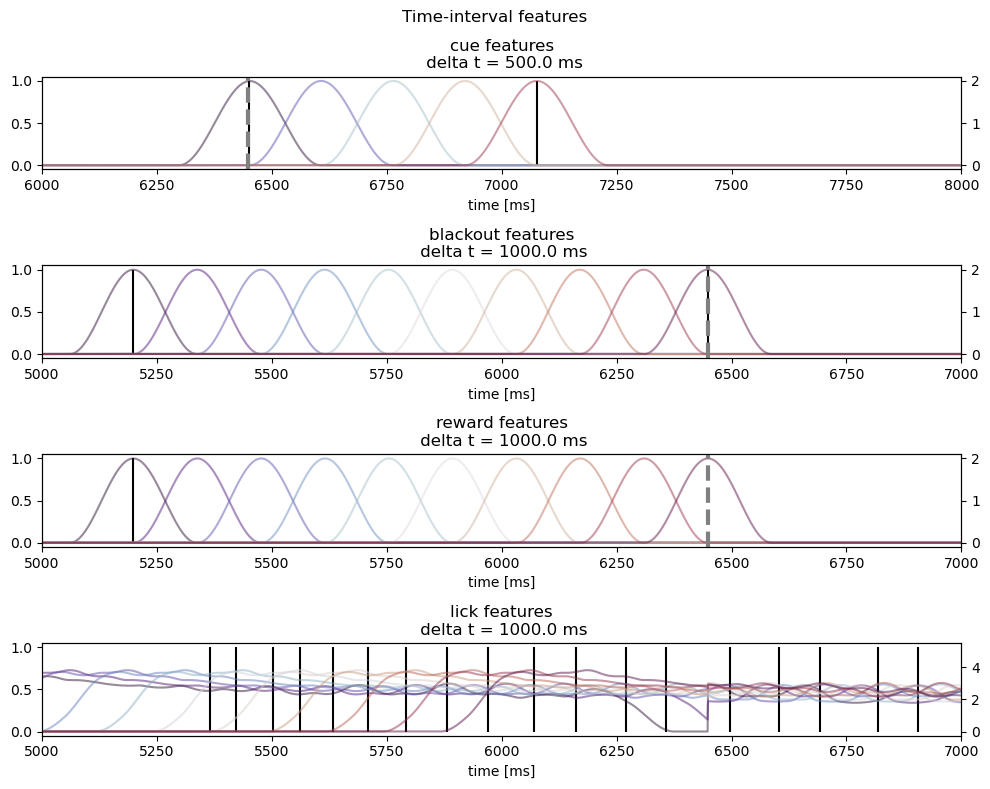

In [16]:
# plot time-interval features
ns = [1, 4, 8, 10] # select trials
raw = pd.concat([ gr_raw.get_group(n) for n in ns ])
prc = pd.concat([ gr_prc.get_group(n) for n in ns ])

fig, axarr = plt.subplots(nrows=4, figsize=(10, 8))
fig.suptitle('Time-interval features')

def vlines(df, cols):
    for col in cols:
        y = df.loc[:, col]
        x = np.arange(len(y.index))
        ax.vlines(x, 0, y, color='k')

def plot(df, cols):
    color = lambda x: plt.cm.twilight_shifted(x / len(cols))
    for i, col in enumerate(cols):
        y = df.loc[:, col]
        x = np.arange(len(y.index))
        ax.plot(x, y, c=color(i), alpha=0.5)

def trial(df):
    t = df.loc[:,'trial']
    for i in t.unique():
        idx = t.loc[ t == i ].index[0]
        x = np.where(t.index == idx)[0]
        ax.axvline(x, c='grey', lw=3, ls='--')

ax = axarr[0]
ax.set_title('cue features\n delta t = {} ms'.format(str(steps2ms(d_cue))))
vlines(raw, ['cue_on', 'cue_off'])
ax = ax.twinx()
plot(prc, [ i for i in prc.columns if i.startswith('cue_')])
trial(prc)
ax.set_xlim(6000, 8000)

ax = axarr[1]
ax.set_title('blackout features\n delta t = {} ms'.format(str(steps2ms(d_blk))))
vlines(raw, ['blk_on', 'blk_off'])
ax = ax.twinx()
plot(prc, [ i for i in prc.columns if i.startswith('blk_')])
trial(prc)
ax.set_xlim(5000, 7000)

ax = axarr[2]
ax.set_title('reward features\n delta t = {} ms'.format(str(steps2ms(d_rwd))))
vlines(raw, ['rwd'])
ax = ax.twinx()
plot(prc, [ i for i in prc.columns if i.startswith('rwd_')])
trial(prc)
ax.set_xlim(5000, 7000)

ax = axarr[3]
ax.set_title('lick features\n delta t = {} ms'.format(str(steps2ms(d_lck))))
vlines(raw, ['lck'])
ax = ax.twinx()
plot(prc, [ i for i in prc.columns if i.startswith('lck_')])
ax.set_xlim(5000, 7000)

for ax in axarr:
    ax.set_xlabel('time [ms]')

fig.tight_layout()

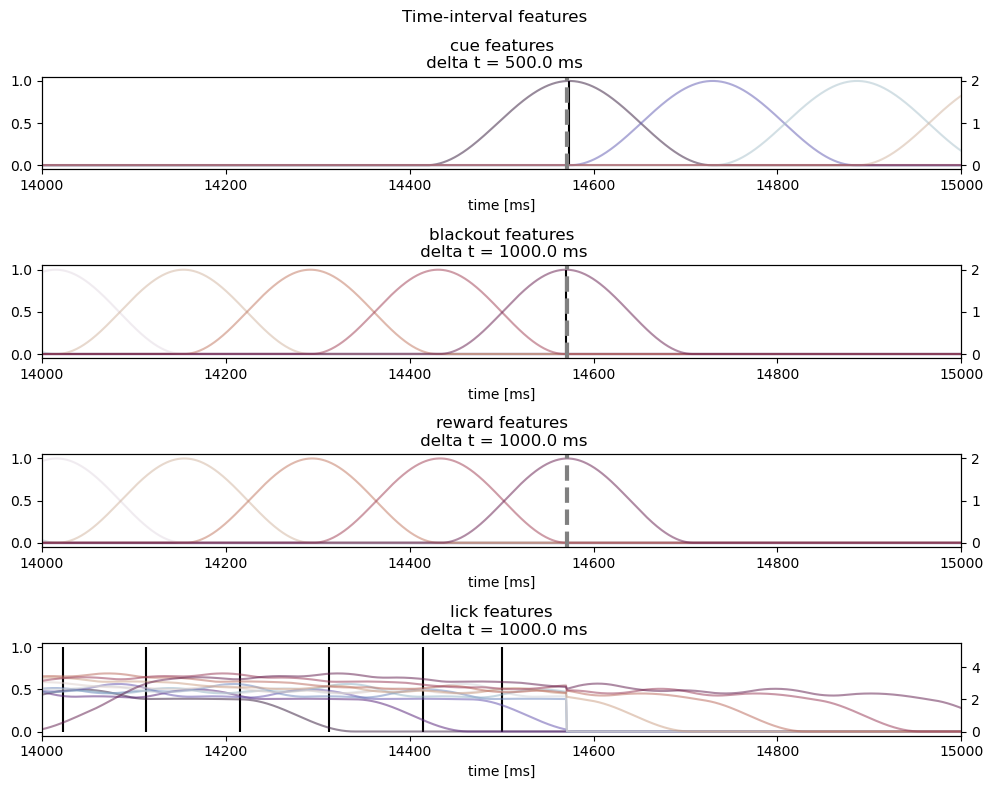

In [17]:
# zoom on non-consecutive trial transition
for ax in axarr:
    ax.set_xlim(14000, 15000)
fig

# Spike processing

In [18]:
# spikes
w_spk = 125 # sigma=125 time steps (100 ms), original code used 5*25=125 time steps
convolve = lambda x, w: np.convolve(x, general_gaussian(M=10*w, p=1, sig=w), mode='same') # convolve with gaussian

df_prc2 = pd.DataFrame(data=df_raw.loc[:, 'trial'], )
gr_prc2 = df_prc2.groupby('trial')

col_spk = [ i for i in df_raw.columns if i.startswith('unt_') ]
for col in col_spk:
    x = df_raw.loc[:, col]
    df_prc.loc[:, col ] = convolve(x, w_spk)   
    df_prc2.loc[:, col ] = x

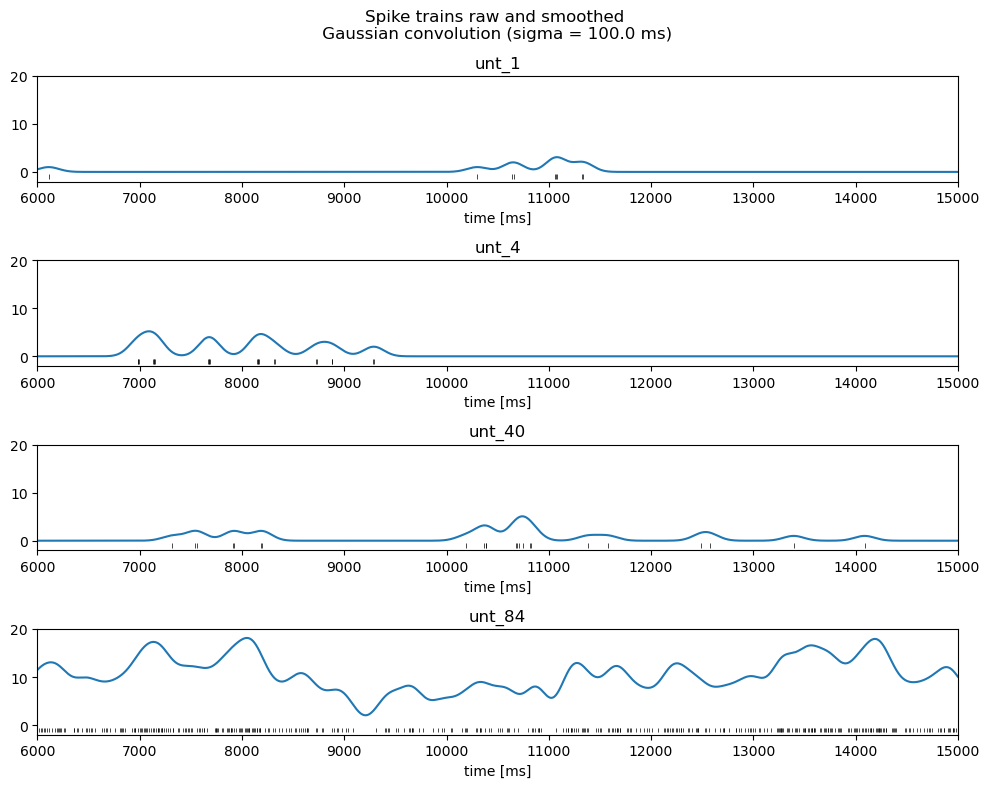

In [19]:
# plot smoothed spikes
ns = [1, 2, 3] # select trials
raw = pd.concat([ gr_raw.get_group(n) for n in ns ])
prc = pd.concat([ gr_prc.get_group(n) for n in ns ])

fig, axarr = plt.subplots(nrows=4, figsize=(10, 8))
fig.suptitle('Spike trains raw and smoothed\n Gaussian convolution (sigma = {} ms)'.format(str(steps2ms(w_spk))))

def raster(df, col):
    'plot columns col from list of dataframes'
    t = df.loc[:, col]
    x = np.where(t == 1)[0]
    x = steps2ms(x)
    ax.eventplot(x, lw=0.5, lineoffset=-1, colors='k')

def plot(df, col):
    y = df.loc[:, col]
    x = np.arange(len(y.index))
    x = steps2ms(x)
    ax.plot(x, y)

for ax, u in zip(axarr, ['unt_{}'.format(str(i)) for i in [1, 4, 40, 84]]):
    ax.set_title(u)
    plot(prc, u)
    raster(raw, u)

for ax in axarr:
    ax.set_xlabel('time [ms]')
    ax.set_xlim(6000, 15000)
    ax.set_ylim((-2, 20))

fig.tight_layout()

# Export

In [43]:
df_prc.to_pickle('./data/preproc/df_prc.pickle')
# df_dwn.to_pickle('./data/preproc/df_prc_dwn.pickle')
# np.save('./data/preproc/ids_good.npy', ids_good)